In [1]:
%load_ext autoreload
%autoreload 2
from wishart import wishart_lib, wishart_lib_stepan
from motifs import motifs
import sys

sys.path.append("..")

from indexes import indexes_lib
from generator import generator_lib
import numpy as np
from matplotlib import pyplot as plt
import importlib
from scipy.interpolate import make_interp_spline, BSpline
from collections import defaultdict
from typing import List

import sys

sys.path.append("..")
importlib.reload(wishart_lib_stepan)
importlib.reload(wishart_lib)
importlib.reload(indexes_lib)
importlib.reload(generator_lib)
importlib.reload(motifs)
from collections import defaultdict
from motifs.motifs import GenerateAllMotifs, GenPatterns
import numpy as np
import pdb
import dill
# from sklearn.datasets.samples_generator import make_blobs
import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score
import seaborn as sn
from statistics import mean
from wishart.wishart_lib import Wishart
from itertools import groupby

# Lorenz attractor visualisation

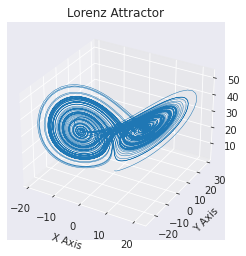

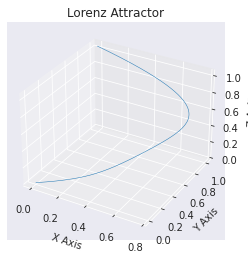

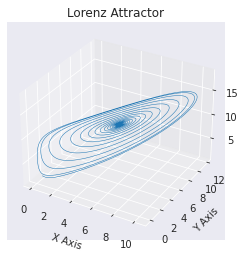

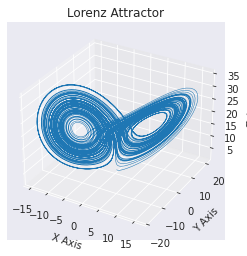

In [2]:
"""
================
Lorenz Attractor
================
"""
import numpy as np
import matplotlib.pyplot as plt


def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return x_dot, y_dot, z_dot


def visualise_lorenz_attractor(s=10, r=28, b=2.667):
    dt = 0.01
    num_steps = 10000

    # Need one more for the initial values
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)

    # Set initial values
    xs[0], ys[0], zs[0] = (0., 1., 1.05)

    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps):
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i], s, r, b)
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.plot(xs, ys, zs, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")

    plt.savefig('Lorenz Attractor')
    plt.show()


visualise_lorenz_attractor()
visualise_lorenz_attractor(r=0.5)
visualise_lorenz_attractor(r=12)
visualise_lorenz_attractor(r=20)

# Lorenz rows 

In [3]:
class Lorenz:
    def __init__(self, s=10, r=28, b=8 / 3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1 / 6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1 / 6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1 / 6)

        return (x, y, z)

    def generate(self, dt=0.1, steps=100000):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array


def lorenz_generation(s=10, r=28, b=8 / 3):
    data, _, _ = Lorenz(s, r, b).generate()
    data = data[250:]
    data = (data - data.min()) / (data.max() - data.min())
    return data


def lorenz_visualisation(data):
    plt.figure(figsize=(20, 8))
    plt.plot(data[:2500])
    plt.xticks([i for i in range(0, 2500, 100)])
    plt.grid()
    plt.show()

# Visualising rows in (r - e, r + e)

99751


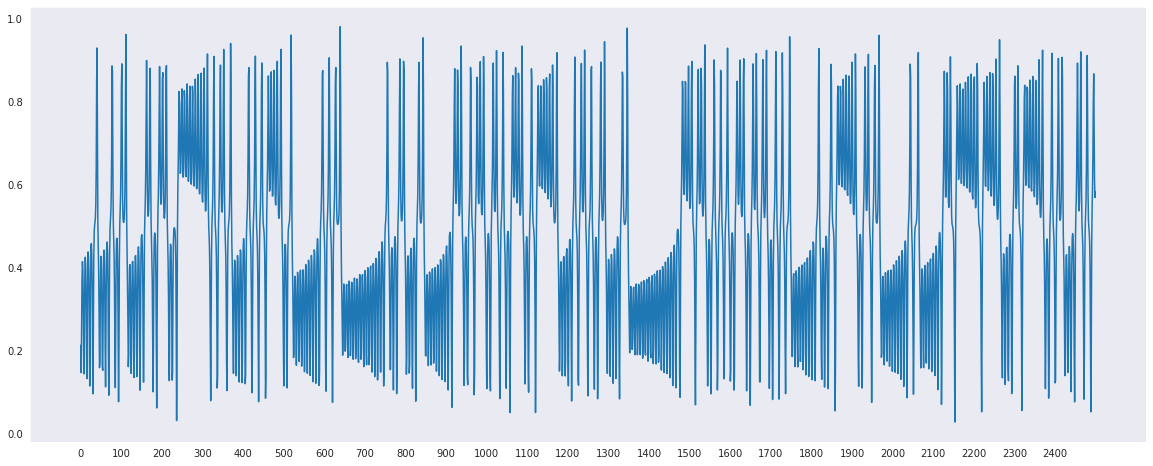

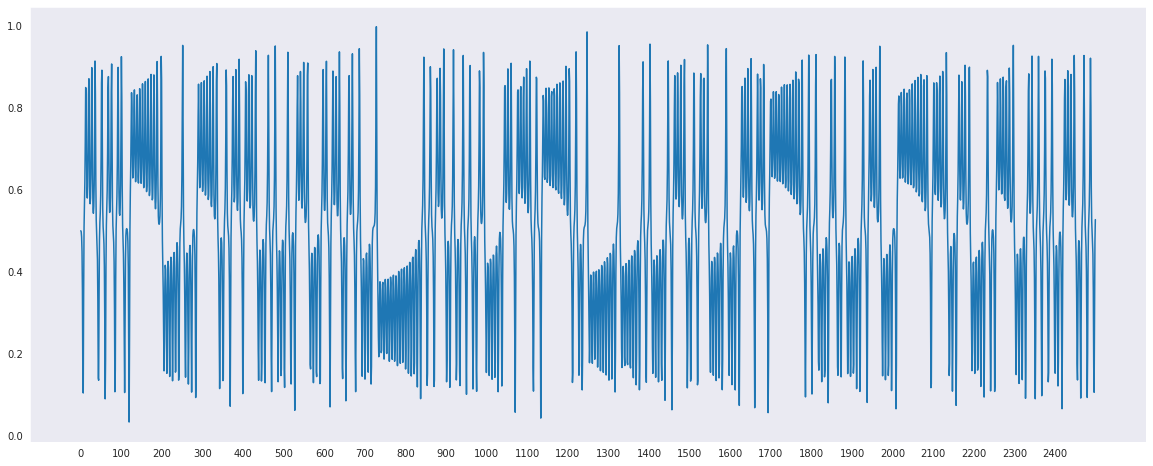

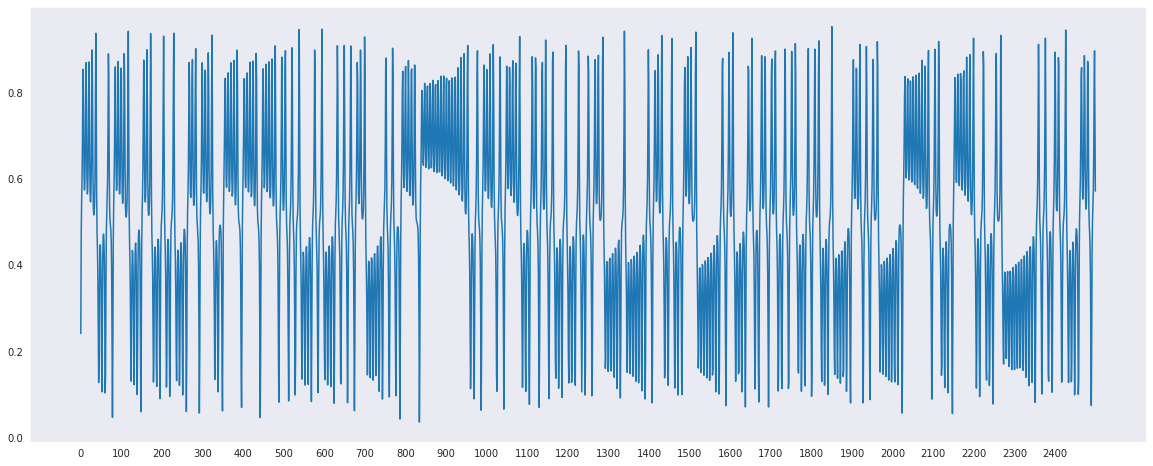

In [4]:
data = lorenz_generation(10, 28.5, 8 / 3)
print(len(data))
lorenz_visualisation(data)
data = lorenz_generation(10, 28, 8 / 3)
lorenz_visualisation(data)
data = lorenz_generation(10, 27.5, 8 / 3)
lorenz_visualisation(data)

In [5]:
def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad):
    val = []
    sum = 0
    for i in range(len(pattern) - 1, -1, -1):
        sum += pattern[i]
        val.append(data[pos - sum])
        if bad[pos - sum]:
            return np.array([])
    val = val[::-1]
    return np.array(val)


def get_val_for_motifs(data: np.array, motif: list, bad):
    val = []
    for i in motif:
        val.append(data[i])
        if bad[i]:
            return np.array([])
    return np.array(val)


def mode(a):
    return max(set(a), key=a.count)


def is_predictable(a):
    return abs(mean(a) - mode(a)) / mode(a) <= 0.1


def get(a):
    return abs(mean(a) - mode(a)) / mode(a)


WISHART_R = 10
WISHART_U = 0.2


def get_centers(x_train):
    N = len(x_train[0])
    wishart = Wishart(WISHART_R, WISHART_U)
    labels = wishart.fit(x_train)
    sorted_by_cluster = sorted(range(len(labels)), key=lambda x: labels[x])
    centers = []
    for wi, cluster in groupby(sorted_by_cluster, lambda x: labels[x]):
        if wi == 0:
            continue
        cluster = list(cluster)
        center = np.full(N, 0.0)
        for i in cluster:
            center += x_train[i]
        centers.append(center / len(cluster))

    return centers

def save_centers(centers, file):
    arr_to_save = []

    for key in centers:
        cur = [key, centers[key]]
        arr_to_save.append(cur)

    np.save(file, np.array(arr_to_save, dtype=object))
    # arr = np.load('centers.npy', allow_pickle=True)
    # return arr
    # print(arr)


In [6]:
class Daemon:
    def __init__(self, mode="simple", is_pred=True, quantiles=(0, 1), gap=0.05):
        self.mode = mode
        self.is_pred = is_pred
        self.quantiles = quantiles
        self.gap = gap

    def mean_d(self, preds):
        sum_weight = sum(map(lambda x: x[1], preds))
        s = sum(map(lambda x: x[0] * x[1], preds))
        return s / sum_weight

    def mean_q(self, preds):
        sum_weight = sum(map(lambda x: x[2], preds))
        s = sum(map(lambda x: x[0] * x[2], preds))
        return s / sum_weight

    def mean_d_q(self, preds):
        cleaned = []
        vals = np.array(preds)[:, 0]
        df = pd.DataFrame(vals)
        low = df[0].quantile(self.quantiles[0])
        high = df[0].quantile(self.quantiles[1])
        for elem in preds:
            if low <= elem[0] <= high:
                cleaned.append(elem)
        if len(cleaned) == 0:
            return None
        sum_weight = sum(map(lambda x: x[1] * x[2], cleaned))
        s = sum(map(lambda x: x[0] * x[1] * x[2], cleaned))
        return s / sum_weight

    def predict(self, possible_values):
        if self.is_pred and not self.is_predictable(possible_values):
            return None
        if self.mode == "simple":
            return np.mean(list(map(lambda x: x[0], possible_values)))
        elif self.mode == "simple_d":
            return self.mean_d(possible_values)
        elif self.mode == "simple_q":
            return self.mean_q(possible_values)
        else:
            return self.mean_d_q(possible_values)
        # return self.mean_q(self.possible_values)

    def is_predictable(self, possible_values):
        vals = np.array(possible_values)[:, 0]
        df = pd.DataFrame(vals)
        low = df[0].quantile(self.quantiles[0])
        high = df[0].quantile(self.quantiles[1])
        if high - low > self.gap:
            return False
        return True


class IdealDeamon(object):
    def __init__(self, real_vals, eps=0.05, mode='simple'):
        self.eps = eps
        self.mode = mode 
        self.real_vals=real_vals
        # self.predictions = po
        
    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, prediction):
        if abs(prediction - self.real_vals[start_point + step]) > self.eps:
            return None
        return prediction
    
    def is_predictable(self, start_point, step, prediction):
       return abs(prediction - self.real_vals[start_point + step]) <= self.eps


def base_prediction(data, daemon: Daemon, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1, QVALUE=0.99,
                    return_possible_values=False):
    t = len(data)
    prediction = np.zeros(shape=(t + h, 2))
    bad = np.array([0 for i in range(t + h)])
    for i in range(t):
        prediction[i][0] = data[i]
        prediction[i][1] = 1
    possible_values = [[] for i in range(h)]

    steps = 0
    for i in range(h):

        for pattern in GenPatterns(L - 1, kmax):
            val_for_pattern_with_q = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)

            if len(val_for_pattern_with_q) == 0:
                continue
            val_for_pattern = val_for_pattern_with_q[:, 0]
            val_q = val_for_pattern_with_q[:, 1]

            for c in centers[pattern]:
                if len(c) == 0:
                    continue
                steps += 1
                dist = np.linalg.norm(c[:-1] - val_for_pattern)
                if dist < eps:
                    weight_d = (eps - dist) / eps
                    weight_q = np.mean(val_q) * QVALUE
                    possible_values[i].append([c[-1], weight_d, weight_q])
                #   possible_values[i].append([c[-1], weight_d, weight_q])

        if len(possible_values[i]):
            pred = daemon.predict(possible_values[i])
            if pred is not None:
                prediction[t + i][0] = pred
            else:
                bad[t + i] = 1
                prediction[t + i][0] = 0
            prediction[t + i][1] = np.mean(list(map(lambda x: x[2], possible_values[i])))
        else:
            bad[t + i] = 1
            prediction[t + i][0] = 0

    
        # print(prediction[t + i])
    print(steps)
    if return_possible_values:
        return [prediction, bad, possible_values]
    return [prediction, bad]

def base_prediction_ideal(data, daemon: Daemon, ideal_daemon: IdealDeamon, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1, QVALUE = 0.99,
                    return_possible_values=False):
    t = len(data)
    prediction = np.zeros(shape=(t + h, 2))
    bad = np.array([0 for i in range(t + h)])
    for i in range(t):
        prediction[i][0] = data[i]
        prediction[i][1] = 1
    possible_values = [[] for i in range(h)]

    steps = 0
    for i in range(h):

        for pattern in GenPatterns(L - 1, kmax):
            val_for_pattern_with_q = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)

            if len(val_for_pattern_with_q) == 0:
                continue
            val_for_pattern = val_for_pattern_with_q[:, 0]
            val_q = val_for_pattern_with_q[:, 1]


            for c in centers[pattern]:
              if len(c) == 0:
                  continue
              steps += 1
              dist = np.linalg.norm(c[:-1] - val_for_pattern)
              if dist < eps:
                  weight_d = (eps - dist) / eps;
                  weight_q = np.mean(val_q) * QVALUE
                  possible_values[i].append([c[-1], weight_d, weight_q])
                #   possible_values[i].append([c[-1], weight_d, weight_q])
                
        if len(possible_values[i]):
            pred = ideal_daemon.predict(0, i, daemon.predict(possible_values[i]))
            if pred is not None:
                prediction[t + i][0] = pred
            else:
                bad[t + i] = 1
                prediction[t + i][0] = 0
            prediction[t + i][1] = np.mean(list(map(lambda x: x[2], possible_values[i])))
        else:
            bad[t + i] = 1
            prediction[t + i][0] = 0

    print(steps)
    return [prediction, bad, possible_values]


def get_mae(preds, actual, bad, h, pref):
    mae = 0
    cnt = 0
    for i in range(pref):
        if bad[i]:
            continue
        print(actual[i], " ", preds[i][0])
        mae += abs(actual[i] - preds[i][0])
        cnt += 1
    if cnt == 0:
        return 0
    return mae / cnt



def get_mse(preds, actual, bad, h, pref):
    mae = 0
    cnt = 0
    for i in range(pref):
        if bad[i]:
            continue
        mae += abs(actual[i] - preds[i][0]) ** 2
        cnt += 1
    if cnt == 0:
        return 0
    return mae / cnt

def get_rmse(preds, actual, bad, h, pref):
    return get_mse(preds, actual, bad, h, pref) ** 0.5

def get_amount_of_predictable_pts(preds, actual, bad, h, pref):
    return sum(bad[:pref]) / pref * 100.0

def smooth_plot(x, y, plt):
    xnew = np.linspace(x.min(), x.max(), 1000) 

    spl = make_interp_spline(x, np.array(y), k=3)
    power_smooth = spl(xnew)
    line, = plt.plot(xnew, power_smooth)
    return line



# Visualisation of graphics when changing eps 

In [7]:
S = 10
R = 28
B = 8 / 3
ROWS_CNT = 8
TRAIN_SIZE = 500
TEST_SIZE = 10000
kmax = 10
L = 4
PRECALCULATED = True
centers = dict()

def values_by_motif(data: np.array, motif: list):
    val = []
    for i in motif:
        val.append(data[i])
    return np.array(val)

def get_metrics(data, h, start_points):
    results = [0] * h
    bads = [0] * h
    for st in start_points:
        prediction, bad, possible = base_prediction_ideal(data[:st], Daemon(mode="simple_d_q", is_pred=False), IdealDeamon(data[st:], 0.05), h, L=4, eps=0.009, return_possible_values=True)
        prediction = prediction[-h:]
        bad = bad[-h:]
        for hz in range(0, h):
            bads[hz] += bad[hz]
            if bad[hz]:
                continue
            results[hz] += (prediction[hz][0] - data[st + hz]) ** 2
    
    for i in range(h):
        if len(start_points) == bads[i]:
            results[i] = 0
        else:
            results[i] /= (len(start_points) - bads[i])
        bads[i] /= len(start_points)
        results[i] **= 0.5
        # 0.5 cause RMSE
    
    
    prefix_bads = [0] * h
    for i in range(h):
        prefix_bads[i] = sum(bads[:(i + 1)]) / (i + 1) * 100        
    return results, prefix_bads

def draw_graphs(val, lx, ly, hz):
    plt.figure(figsize=(18, 12))
    smooth_plot(np.array(range(1, hz + 1)), np.array(val), plt).set_label("Simple")
    plt.xlabel(lx, size=20)
    plt.ylabel(ly, size=20)
    plt.show()

def precalc_lorentz_by_eps(eps: float):
    mtf = GenerateAllMotifs(kmax, L, TRAIN_SIZE - 1)
    mtf_by_patterns = defaultdict(list)

    if not PRECALCULATED:
        for it in range(ROWS_CNT):
            r = R - eps + 2.0 * eps / (ROWS_CNT - 1) * it
            train_data = lorenz_generation(S, r, B)[:TRAIN_SIZE]
            for pattern, all_motifs in mtf:
                vals = [values_by_motif(train_data, motif) for motif in all_motifs]
                for v in vals:
                    mtf_by_patterns[pattern].append(v)
        
        for pattern in mtf_by_patterns.keys():
            centers[pattern] = get_centers(mtf_by_patterns[pattern])
        save_centers(centers, 'centers_lorenz.npy')
    else:
        loaded = np.load('centers_lorenz.npy', allow_pickle=True)
        for k, v in loaded:
            centers[k] = v
precalc_lorentz_by_eps(0.3)

o_data = lorenz_generation(S, R, B)
train_data = o_data[:TRAIN_SIZE]
test_data = o_data[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]
h = 100
prediction, bad, possible = base_prediction(train_data, Daemon(mode="simple_d_q", is_pred=False), h, L=4, eps=0.009, return_possible_values=True)
prediction_ideal, bad_ideal, possible_ideal = base_prediction_ideal(train_data, Daemon(mode="simple_d_q", is_pred=False), IdealDeamon(test_data, 0.05), h, L=4, eps=0.009, return_possible_values=True)

6731955
846775


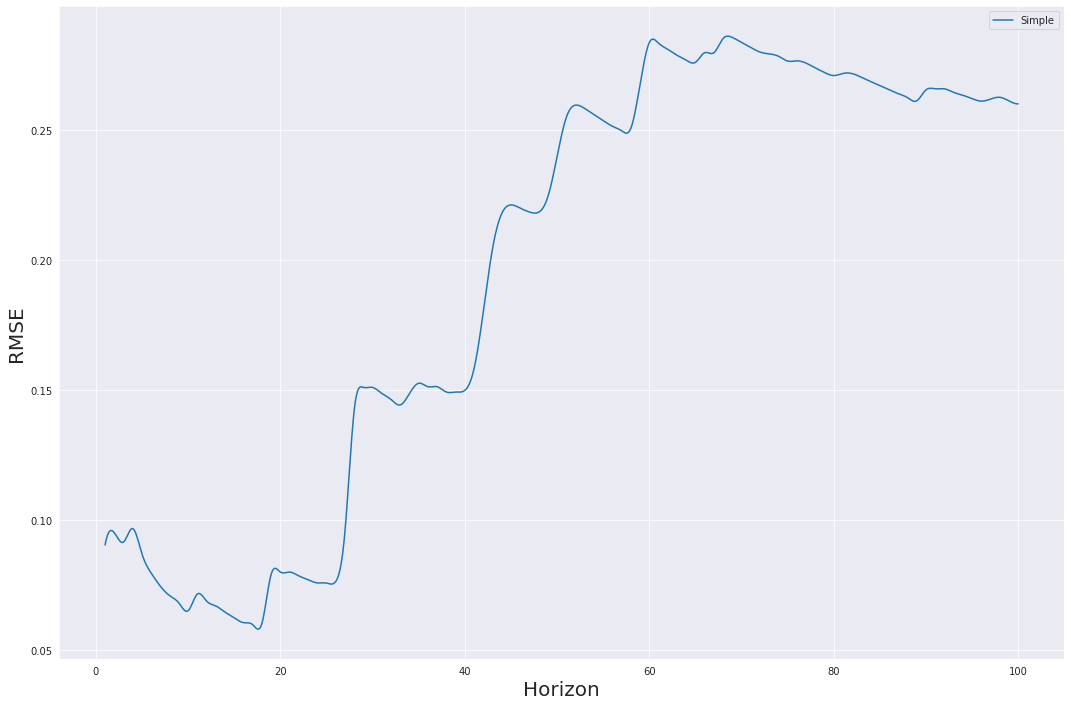

In [8]:
prediction = prediction[-h:]
bad = bad[-h:]
prediction_ideal = prediction_ideal[-h:]
bad_ideal = bad_ideal[-h:]

mse_val = [get_rmse(prediction, test_data, bad, h, i) for i in range(1, h + 1)]
plt.figure(figsize=(18, 12))
smooth_plot(np.array(range(1, h + 1)), np.array(mse_val), plt).set_label("Simple")


plt.legend()
plt.xlabel("Horizon", size=20)
plt.ylabel("RMSE", size=20)
plt.show()



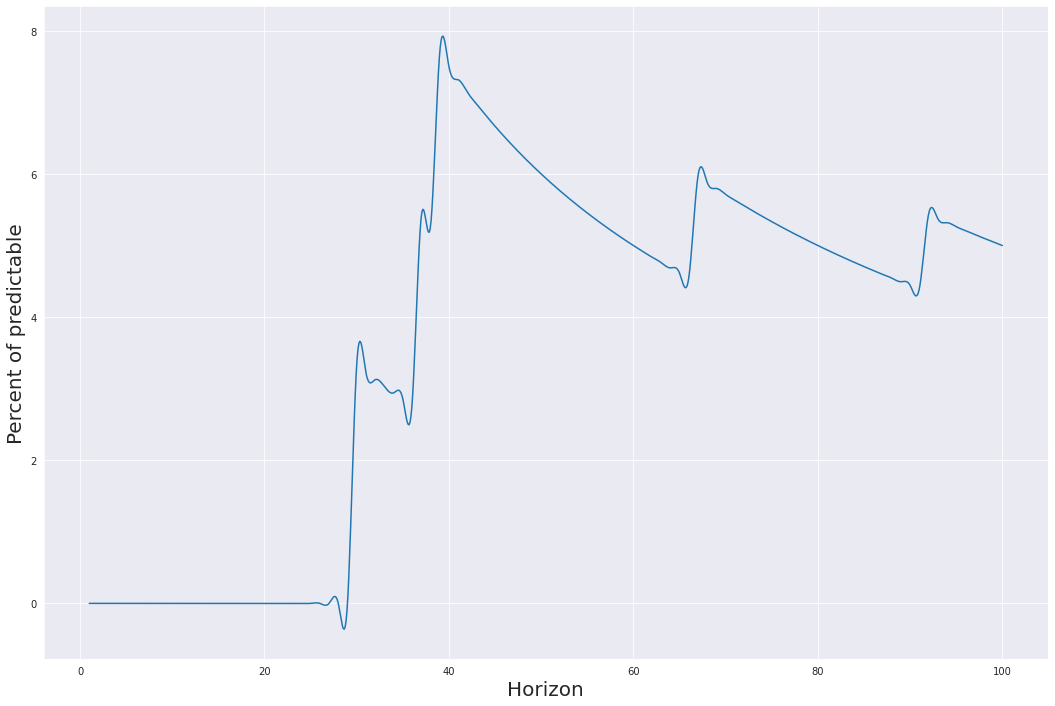

In [9]:
pred_cnt = [get_amount_of_predictable_pts(prediction, test_data, bad, h, i) for i in range(1, h + 1)]
plt.figure(figsize=(18, 12))
smooth_plot(np.array(range(1, h + 1)), np.array(pred_cnt), plt).set_label("Simple")
plt.xlabel("Horizon", size=20)
plt.ylabel("Percent of predictable", size=20)
plt.show()

In [10]:
pts = 100
start_points = random.sample([i for i in range(1000, 1500)], pts)
results, prefix_bads = get_metrics(o_data, h, start_points)

draw_graphs(results, "Horizon", "RMSE", h)
draw_graphs(prefix_bads, "Horizon", "Percent of non-pred", h)

2100979
2225438
1779479
1468021
1254397
3163831
577952
804323
1384866
818052
868860
754049
1591080
907753
2153850
1270046
1230202
1509463
1364644
1512043
1026624
1982343
3163030
586172
679838


KeyboardInterrupt: 